In [1]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
print(tf.__version__)

2.0.0-beta0


# Auto MPG data

In [2]:
# dataset_path = keras.utils.get_file("auto-mpg.data",
#                                     "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
# dataset_path
dataset_path = '/Volumes/TimeMachine/data/DR7/eBOSS.ELG.NGC.DR7.table.5.r.npy'

In [3]:
data = np.load(dataset_path, allow_pickle=True).item()
data.keys()

dict_keys(['test', 'train', 'validation'])

In [4]:
class DATA(object):
    def __init__(self, data):
        self.x = data['features']
        self.y = data['label']
        self.p = data['hpind']
        self.w = data['fracgood']
    def norm_it(self, train_stats):
        self.X = (self.x - train_stats['x']['mean'])/train_stats['x']['std']
        self.Y = (self.y - train_stats['y']['mean'])/train_stats['y']['std']        

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: print('')
        print('.', end='')
        
#
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(8, 8))
    plt.subplots_adjust(hspace=0.0)
    # fig 0
    ax[0].set_ylabel('Mean Abs Error')
    ax[0].plot(hist['epoch'], hist['mae'],
           label='Train Error')
    ax[0].plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error', ls='--')
    # fig 1 
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Square Error')
    ax[1].plot(hist['epoch'], hist['mse'],
           label='Train Error')
    ax[1].plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error', ls='--')
    ax[0].legend()
    plt.show()

In [5]:
train = DATA(data['train']['fold3'])
test  = DATA(data['test']['fold3'])
valid = DATA(data['validation']['fold3'])
train

In [6]:
train_stats = {'x':{'mean':np.mean(train.x, axis=0), 
                    'std':np.std(train.x, axis=0, ddof=1)},
               'y':{'mean':np.mean(train.y, axis=0), 
                    'std':np.std(train.y, axis=0, ddof=1)}}

In [7]:
train.norm_it(train_stats)
test.norm_it(train_stats)
valid.norm_it(train_stats)

In [8]:
train.X.shape

(112355, 18)

In [39]:
def build_model(nfeature):
    tf.keras.backend.clear_session()
    kwargs = dict(kernel_regularizer=keras.regularizers.l2(0.0),
                  kernel_initializer=keras.initializers.he_normal(seed=123456))
    model = keras.Sequential([
        layers.Dense(20, activation='relu', input_shape=[nfeature], **kwargs),
        layers.Dense(20, activation='relu', **kwargs),
        layers.Dense(1, **kwargs)
        ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [40]:
model = build_model(18)

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                380       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 821
Trainable params: 821
Non-trainable params: 0
_________________________________________________________________


In [42]:
example_batch  = train.X[:10]
example_result = model.predict(example_batch)
example_result

array([[0.9392197 ],
       [0.6460737 ],
       [0.60917574],
       [1.5320244 ],
       [1.7905174 ],
       [1.697375  ],
       [0.7331297 ],
       [0.8881485 ],
       [0.8687571 ],
       [0.8918803 ]], dtype=float32)

In [43]:
model = build_model(18)
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=1.e-6)
EPOCHS = 1000
history = model.fit(
                train.X, train.Y,
                epochs=EPOCHS, validation_data=(valid.X, valid.Y), verbose=0,
                callbacks=[early_stop, PrintDot()], batch_size=256)



..........
..........
..........
..........
..........
..........
..........
.........

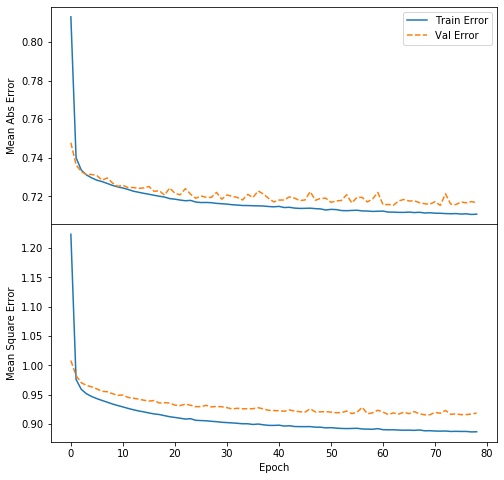

In [44]:
plot_history(history)

In [45]:
loss, mae, mse = model.evaluate(test.X, test.y, verbose=0)

print("Testing set Mean Abs Error : {:5.2f}\nTesting set Mean Square Error : {:5.2f}".format(mae, mse))

Testing set Mean Abs Error :  1.01
Testing set Mean Square Error :  1.19


In [46]:
pd.DataFrame(history.history).tail()

,loss,mae,mse,val_loss,val_mae,val_mse
74,0.887824,0.711063,0.887823,0.917534,0.715718,0.917534
75,0.887641,0.710812,0.887641,0.916205,0.717099,0.916204
76,0.887640,0.710958,0.887641,0.916343,0.716628,0.916343
77,0.886833,0.710598,0.886833,0.917241,0.717294,0.917241
78,0.887083,0.710785,0.887083,0.918935,0.716672,0.918935


(-3.7188560602361123,
 17.18660314782643,
 -4.6479181709142185,
 16.25754103714832)

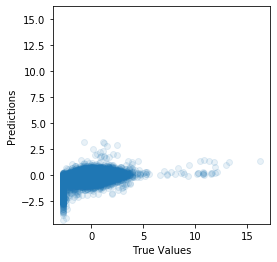

In [47]:
test_predictions = model.predict(test.X).flatten()

plt.scatter(test.Y, test_predictions, alpha=0.1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
# plt.xlim([0,plt.xlim()[1]])
# plt.ylim([0,plt.ylim()[1]])
# _ = plt.plot([-100, 100], [-100, 100])

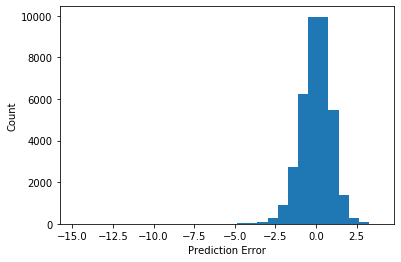

In [48]:
error = test_predictions - test.Y
plt.hist(error, bins=30)
plt.xlabel("Prediction Error")
# plt.yscale('log')
_ = plt.ylabel("Count")